In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from ancestrator import *
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
def all_gal_panels():
    aims_count = lambda p: len(Panel(p).snps)
    labels = [l for l in Panel.available_panels()
              if re.match('(GAL_C|GAL_A)', l)]
    panel_labels = sorted(labels, key=aims_count, reverse=True)
    return panel_labels

# Fst per locus

In [138]:
from itertools import product

source_labels = ['1000Genomes']
samplegroup_labels = ['NE', 'NA', 'EA']
panel_labels = ["CPx100", "CPx10", "CPx1"] + all_gal_panels()

frames = []
combo = product(source_labels, panel_labels, samplegroup_labels)
for source_label, panel_label, samplegroup_label in combo:
    dataset = Dataset(source_label, samplegroup_label, panel_label)
#     if dataset.samplegroup.label == 'L':
#         df = dataset.fst('population')
#         df['level'] = 'population'
#     else:
    df = dataset.fst('region')
    df['level'] = 'region'
    df['samplegroup'] = dataset.samplegroup.label
    df['panel'] = panel_label
    frames.append(df)

fst = pd.concat(frames)

mean_fst = fst.groupby(['level', 'samplegroup', 'panel']).mean().unstack('panel')['Fst']
mean_fst = mean_fst[panel_labels]  # Sorts the columns
# mean_fst.columns = [Panel(panel_label).name for panel_label in mean_fst.columns]

cum_fst = fst.groupby(['level', 'samplegroup', 'panel']).sum().unstack('panel')['Fst']
cum_fst = cum_fst[panel_labels]  # Sorts the columns
# cum_fst.columns = [Panel(panel_label).name for panel_label in cum_fst.columns]

mean_fst

panel                 CPx100     CPx10      CPx1  GAL_Completo  GAL_Affy  \
level  samplegroup                                                         
region EA           0.091205  0.091512  0.094607      0.471556  0.513198   
       NA           0.155176  0.152708  0.150843      0.478561  0.510129   
       NE           0.086584  0.086783  0.083451      0.421196  0.380013   

panel               GAL_Affy_SubPanel_155  GAL_Affy_SubPanel_150  \
level  samplegroup                                                 
region EA                        0.486288               0.487468   
       NA                        0.482448               0.483025   
       NE                        0.423244               0.428238   

panel               GAL_Affy_SubPanel_145  GAL_Affy_SubPanel_140  \
level  samplegroup                                                 
region EA                        0.486357               0.483815   
       NA                        0.487756               0.487345   
       NE                        0.431461               0.435689   

panel               GAL_Affy_SubPanel_135         ...           \
level  samplegroup                                ...            
region EA                        0.481742         ...            
       NA                        0.481873         ...            
       NE                        0.437284         ...            

panel               GAL_Affy_SubPanel_50  GAL_Affy_SubPanel_45  \
level  samplegroup                                               
region EA                       0.517415              0.516987   
       NA                       0.513827              0.503749   
       NE                       0.496801              0.507455   

panel               GAL_Affy_SubPanel_40  GAL_Affy_SubPanel_35  \
level  samplegroup                                               
region EA                       0.525475              0.528760   
       NA                       0.504562              0.529760   
       NE                       0.513450              0.514752   

panel               GAL_Affy_SubPanel_30  GAL_Affy_SubPanel_25  \
level  samplegroup                                               
region EA                       0.538709              0.534891   
       NA                       0.523040              0.535749   
       NE                       0.513066              0.523275   

panel               GAL_Affy_SubPanel_20  GAL_Affy_SubPanel_15  \
level  samplegroup                                               
region EA                       0.549854              0.525606   
       NA                       0.527335              0.526603   
       NE                       0.525758              0.554020   

panel               GAL_Affy_SubPanel_10  GAL_Affy_SubPanel_5  
level  samplegroup                                             
region EA                       0.561698             0.464244  
       NA                       0.536544             0.557184  
       NE                       0.554074             0.600168  

[3 rows x 36 columns]

In [139]:
fst = fst.reset_index().fillna(0)  # Replace NaN (probably caused by absence of heterocygotes)
fst = fst.drop_duplicates(subset=['rs_id', 'samplegroup'])
fst = fst.set_index(['rs_id', 'samplegroup'])[['level', 'Fst']]
fst.loc[fst['Fst'] < 0, 'Fst'] = 0  # Replace negative values (vcftools bug) with 0!
fst.head()

,,level,Fst
rs_id,samplegroup,,
rs9701055,NE,region,0.000000
rs111378522,NE,region,0.000000
rs2465134,NE,region,0.012736
rs4072537,NE,region,0.086650
rs79314543,NE,region,0.000000


# LSBL per SNP per ancestry (based in 1000Genomes frequencies)

In [140]:
samplegroups_for_ancestry = {
    ('NAM'): ['NE', 'NA', 'EA'],
    ('AFR'): ['NA', 'EA', 'NE'],
    ('EUR'): ['EA', 'NE', 'NA'],
}

lsbl = pd.DataFrame({'NAM': [], 'EUR': [], 'AFR': []})

# for i, rs_id in enumerate(fst.index.get_level_values('rs_id').unique()):
#     if i % 1000 == 0:z
#     print(i, rs_id)

for rs_id in Panel('GAL_Completo').snps.index:
    for ancestry, (sg1, sg2, sg3) in samplegroups_for_ancestry.items():
        branch1 = fst.loc[(rs_id, sg1)]['Fst']
        branch2 = fst.loc[(rs_id, sg2)]['Fst']
        branch3 = fst.loc[(rs_id, sg3)]['Fst']
        
        # See Shriver et al. 2004 for this formula
        lsbl.loc[rs_id, ancestry] = (branch1 + branch2 - branch3) / 2

In [ ]:
# Followring Shriver et al. 2004:
# Add .35 so no values are negative
# Compute the inverse of the values so they approach normality

# lsbl_corrected = lsbl.apply(lambda series: 1/(series + 0.35))

# Crear subpaneles de GAL_Affy que balanceen el $F_{ST}$ o LSBL de los 3  SampleGroups: NE NA EA

**NOTA**: acá uso el LSBL calculado por mí en función de los genotipos de las muestras de 1000 Genomes. El resultado fueron subpaneles balanceados para ese LSBL, pero diferentes respecto de GAL_Completo, cuyo balance dependía de un LSBL calculado con otras muestras. Por ende, reharé los subpaneles utilizando exclusivamente el LSBL provisto por Galanter et. al en su paper, de modo que el balanceo sea similar.

Crear subpaneles utilizando el LSBL basado en el Fst:

1. Para cada SNP, calcular el LSBL por ancestría (NAM, EUR, AFR) usando la fórmula de Shriver et al. 2004. Esto depende del Fst en los tres datasets (NA, NE, EA), que ya tengo calculado.
2. Elegir un primer SNP que maximice el LSBL-NAM. Los SNPs disponibles son los del `source_panel` (`GAL_Affy` en mi caso). Quitar el SNP elegido de esa lista de disponibles para no repetir la elección luego.
3. En el nuevo panel, ver qué ancestría tiene menos LSBL acumulado. Para esa ancestría, elegir el SNP que mayor LSBL le dé de los disponibles. Agregar ese SNP al nuevo panel, quitarlo de los disponibles.
4. Repetir (3) hasta que el nuevo panel tenga la cantidad de SNPs deseada.

In [81]:
# LSBL based
#     -- NOTE: Ya creé los subpaneles, no hace falta correr esto de nuevo. --

# def add_snp_to_new_panel(available_snps, ancestry, new_panel_df):
#     top_snp_id = available_snps[ancestry].idxmax()
#     top_snp_data = available_snps.loc[top_snp_id]
#     new_panel_df = new_panel_df.append(top_snp_data)
#     available_snps.drop(top_snp_id, inplace=True)
#     return new_panel_df

# desired_lengths = np.arange(5, 180, 5)
# # desired_lengths = [50]
# subpanels = []
# source_panel = Panel('GAL_Affy')

# for desired_length in desired_lengths:
#     available_snps = lsbl.copy()
#     new_panel_df = pd.DataFrame({})

#     # First AIMs
#     new_panel_df = add_snp_to_new_panel(available_snps, 'NAM', new_panel_df)
#     new_panel_df = add_snp_to_new_panel(available_snps, 'EUR', new_panel_df)
    
#     # Rest of AIMs
#     for n in np.arange(desired_length - 2):
#         min_cum_lsbl = new_panel_df.sum().idxmin()
#         new_panel_df = add_snp_to_new_panel(available_snps, min_cum_lsbl, new_panel_df)

#     # Create the panel and 'ALL' dataset files for '1000Genomes'
#     new_panel = source_panel.create_subpanel(new_panel_df.index, source_label='1000Genomes')
#     subpanels.append(new_panel)
    
#     print(new_panel.label)
#     print(new_panel_df.sum().values)
#     print()

Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_5.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_5.snps
You can now call Panel('GAL_Affy_SubPanel_5')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_5') with any SampleGroup
GAL_Affy_SubPanel_5
[ 1.727645  1.588847  1.070386]

Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_10.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_10.snps
You can now call Panel('GAL_Affy_SubPanel_10')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_10') with any SampleGroup
GAL_Affy_SubPanel_10
[ 2.58356392  3.14042903  3.07377407]

Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_15.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_15.snps
You can now call Panel('GAL_Affy_SubPanel_15')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_15') with any SampleGroup
GAL_Affy_SubPanel_15
[ 4.32490658  4.53340738

In [95]:
# # Fst based
# #     -- NOTE: Ya creé los subpaneles, no hace falta correr esto de nuevo. --


# def add_snp_to_new_panel(source_panel_fst, fst_column, new_panel_df):
#     top_snp_id = source_panel_fst[fst_column].idxmax()
#     top_snp_data = source_panel_fst.loc[top_snp_id]
#     new_panel_df = new_panel_df.append(top_snp_data)
#     source_panel_fst.drop(top_snp_id, inplace=True)
#     return new_panel_df

# desired_lengths = np.arange(5, 180, 5)
# # desired_lengths = [100]
# subpanels = []

# for desired_length in desired_lengths:
#     # Prepare the source of AIMs
#     source_panel = Panel('GAL_Affy')
#     source_panel_fst = fst[(fst.panel == source_panel.label) & (fst.level == 'region')]
#     source_panel_fst = source_panel_fst[['Fst', 'samplegroup']].reset_index()
#     source_panel_fst = source_panel_fst.pivot_table(values='Fst', index='rs_id',
#                                                     columns='samplegroup')

#     new_panel_df = pd.DataFrame({})

#     # First AIM
#     new_panel_df = add_snp_to_new_panel(source_panel_fst, 'EA', new_panel_df)
    
#     # Rest of AIMs
#     for n in np.arange(desired_length - 1):
#         min_cum_fst = new_panel_df.sum().idxmin()
#         new_panel_df = add_snp_to_new_panel(source_panel_fst, min_cum_fst, new_panel_df)

#     # Create the panel and 'ALL' dataset files for '1000Genomes'
#     new_panel = source_panel.create_subpanel(new_panel_df.index, source_label='1000Genomes')
#     subpanels.append(new_panel)
#     print(new_panel.label)

> /home/juan/repos/ancestrator/components/panel.py(128)write_bim()
-> snps_df.to_csv(bim_filepath, header=False, index=False, sep='\t')
(Pdb) snps_df.head()
   chr      rs_id  morgans   position A1 A2
0    5  rs6875659        0  175158653  A  G
1    2  rs1036543        0  133676214  G  A
2   11  rs1790740        0   67130122  G  A
3   11   rs174570        0   61597212  T  C
4   22  rs5757362        0   39306080  T  C
(Pdb) c
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_100.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_100.snps
You can now call Panel('GAL_Affy_SubPanel_100')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_100') with any SampleGroup
GAL_Affy_SubPanel_100


In [135]:
# Usando el LSBL de Galanter et al.!

#     -- NOTE: Ya creé los subpaneles, no hace falta correr esto de nuevo. --


galanter_lsbl = Panel('GAL_Completo').extra_info[['population', 'LSBL(Fst)']]

def add_snp_to_new_panel(available_snps, ancestry, new_panel_df):
    mask = available_snps.population == ancestry
    top_snp_id = available_snps[mask]['LSBL(Fst)'].idxmax()
    top_snp_data = available_snps.loc[top_snp_id]
    new_panel_df = new_panel_df.append(top_snp_data)
    available_snps.drop(top_snp_id, inplace=True)
    return new_panel_df

desired_lengths = np.arange(5, 180, 5)
# desired_lengths = [100]
subpanels = []
source_panel = Panel('GAL_Affy')

for desired_length in desired_lengths:
    available_snps = galanter_lsbl.copy().loc[source_panel.snps.index]
    new_panel_df = pd.DataFrame({})

    # First AIMs
    new_panel_df = add_snp_to_new_panel(available_snps, 'NAM', new_panel_df)
    new_panel_df = add_snp_to_new_panel(available_snps, 'EUR', new_panel_df)
    new_panel_df = add_snp_to_new_panel(available_snps, 'AFR', new_panel_df)
    
    # Rest of AIMs
    for n in np.arange(desired_length - 3):
        min_cum_lsbl = new_panel_df.groupby('population').sum()['LSBL(Fst)'].idxmin()
        new_panel_df = add_snp_to_new_panel(available_snps, min_cum_lsbl, new_panel_df)

    # Create the panel and 'ALL' dataset files for '1000Genomes'
    new_panel = source_panel.create_subpanel(new_panel_df.index, source_label='1000Genomes')
    subpanels.append(new_panel)
    
    print(new_panel.label)
    print(new_panel_df.groupby('population')['LSBL(Fst)'].sum().values)
    print()

Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_5.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_5.snps
You can now call Panel('GAL_Affy_SubPanel_5')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_5') with any SampleGroup
GAL_Affy_SubPanel_5
[ 0.835  1.194  1.52 ]

Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_10.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_10.snps
You can now call Panel('GAL_Affy_SubPanel_10')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_10') with any SampleGroup
GAL_Affy_SubPanel_10
[ 2.377  2.24   2.22 ]

Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_15.bim
Written -> /home/juan/tesina/panel_info_files/GAL_Affy_SubPanel_15.snps
You can now call Panel('GAL_Affy_SubPanel_15')
You can now call Dataset('1000Genomes', 'ALL', 'GAL_Affy_SubPanel_15') with any SampleGroup
GAL_Affy_SubPanel_15
[ 3.135  3.213  3.584]

Written -> /home/juan/te

ValueError: attempt to get argmax of an empty sequence

# Compute mean and cum 1000G-LSBL for each panel

In [137]:
cum_lsbl = pd.DataFrame({})
mean_lsbl = pd.DataFrame({})

for panel_label in all_gal_panels():
    snps = Panel(panel_label).snps
    summed_lsbl = lsbl.loc[snps.index].sum()
    summed_lsbl.name = panel_label
    cum_lsbl = cum_lsbl.append(summed_lsbl)
    mean_lsbl = mean_lsbl.append(summed_lsbl / len(snps))
    
print(cum_lsbl.head(10))
print()
print(mean_lsbl.head(10))

                              AFR        EUR        NAM
GAL_Completo           118.097440  91.761998  96.168507
GAL_Affy                57.711848  34.154728  34.147852
GAL_Affy_SubPanel_155   42.419880  32.958851  32.878178
GAL_Affy_SubPanel_150   40.796598  32.327713  32.142323
GAL_Affy_SubPanel_145   39.461109  31.064746  31.731318
GAL_Affy_SubPanel_140   37.607815  30.130339  31.059411
GAL_Affy_SubPanel_135   35.652124  29.387128  29.839573
GAL_Affy_SubPanel_130   34.319046  28.564281  28.904297
GAL_Affy_SubPanel_125   33.098291  27.271139  28.220138
GAL_Affy_SubPanel_120   31.173762  26.450251  27.550930

                            AFR       EUR       NAM
GAL_Completo           0.265388  0.206207  0.216109
GAL_Affy               0.322413  0.190809  0.190770
GAL_Affy_SubPanel_155  0.273677  0.212638  0.212117
GAL_Affy_SubPanel_150  0.271977  0.215518  0.214282
GAL_Affy_SubPanel_145  0.272146  0.214240  0.218837
GAL_Affy_SubPanel_140  0.268627  0.215217  0.221853
GAL_Affy_SubPanel_1

^ Según la población de 1000 Genomas, los paneles GAL ahora sobreestiman ancestría africana. Pero bueno, al menos son *consistentes* en eso y los tests me van a dar bien.

# $F_{ST}$ Latinos (between populations) & LEA (between regions)

# New $F_{ST}$ comparisons

* Crear tres nuevos SampleGroups: NE, NA, EA (producto de NAM, EUR, AFR), seleccionando como NAM a los peruanos y mexicanos ~100% americanos según el primer análisis de PCA/Admixture.

* Evaluar el $F_{ST}$ acumulado de cada panel (incluir los CPx!) con los nuevos datasets (o sea, cuánto diferencia cada panel entre Nativos vs Europeos, Nativos vs Africanos, Africanos vs Europeos). La idea de utilizar el Fst *acumulado* es que los paneles CPx van a tener un número mucho más alto y van a demostrar ser mejores que los GAL. En promedio, sin embargo, los GAL van a tener un Fst mucho más alto, por supuesto, porque no se mezclan los AIMs informativos con SNPs de origen ambiguo.

* En rigor, no sé si comparar a los paneles con el Fst promedio o el Fst acumulado. Supongo que este último?


Fst promedio (todos los datasets)
/home/juan/tesina/charts/panel_analyses/fst_barchart__region


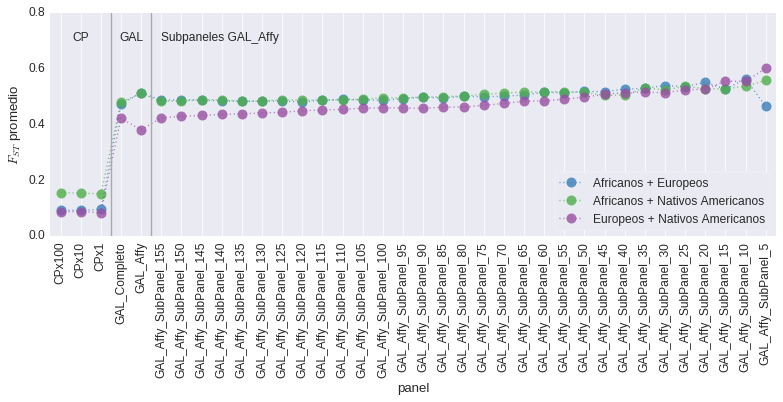

In [142]:
import numpy as np
from os.path import expanduser, join


fdir = expanduser("~/tesina/charts/panel_analyses")

sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")

for level in ['region']:
    df = mean_fst.loc[level].copy()

    if level == 'population':
        color = sns.color_palette("Set1", 1)[0]
        sns.set_context("paper", font_scale=1.2)
        figsize = (13, 2)
    else:  
        color = sns.color_palette("Set1", 5)[1:]
        figsize = (13, 4)
        
    ax = df.T.plot(figsize=figsize, rot=90, color=color, linestyle="dotted",
                   marker="o", markersize=10, alpha=0.8) #, width=0.8) # kind="bar", 
    ax.set_ylabel("$F_{ST}$ promedio")
    ax.legend(fancybox=True, loc="best", bbox_to_anchor=(1.01, .75),
              title="Datasets")

    # Annotate groups of panels
    ax.axvline(2.5, color="darkgray")
    ax.axvline(4.5, color="darkgray")
    text_yloc = 0.7 if level == 'region' else 0.125
    texts = [(1, text_yloc, "CP"),
             (3.5, text_yloc, "GAL"),
             (5, text_yloc, "Subpaneles GAL_Affy")]
    for params in texts:
        halign = 'center' if params[-1] in ['CP', 'GAL'] else 'left'
        ax.text(*params, fontsize=12, horizontalalignment=halign)

    if level == 'region':
        ax.set_ylim([0, .8])
        ygrid_points = np.linspace(0, .8, 5)
        ax.set_yticks(ygrid_points)
    else:
        ax.set_ylim([0, 0.15])
        ygrid_points = np.linspace(0, 0.15, 4)
        ax.set_yticks(ygrid_points)
        
    ax.set_xlim([-0.5, len(panel_labels) - 0.5])

    ax.set_xticks(np.arange(len(panel_labels)))
    ax.set_xticklabels(panel_labels, rotation=90)
    sns.despine(left=True)
    ax.yaxis.grid(False)

    handles, labels = ax.get_legend_handles_labels()
    if level == 'region':
        labels = [SampleGroup('1000Genomes', l).name for l in labels]
        ax.legend(handles, labels, frameon=True, fancybox=True, loc='lower right')
    else:
#         ax.legend(handles, labels, frameon=True, fancybox=True, loc='lower right')
        ax.legend_.set_visible(False)

    caption = "Fst promedio (todos los datasets)"
    
    filepath = join(fdir, "fst_barchart__{}".format(level))
    plt.savefig(filepath, bbox_inches="tight")
    print(caption)
    print(filepath)
    plt.show()

/home/juan/tesina/charts/panel_analyses/LSBL_acumulado_por_ancestria_y_subpanel
Esto es una razón para esperar una peor estimación de GAL_Affy que de su subpanel inmediato.


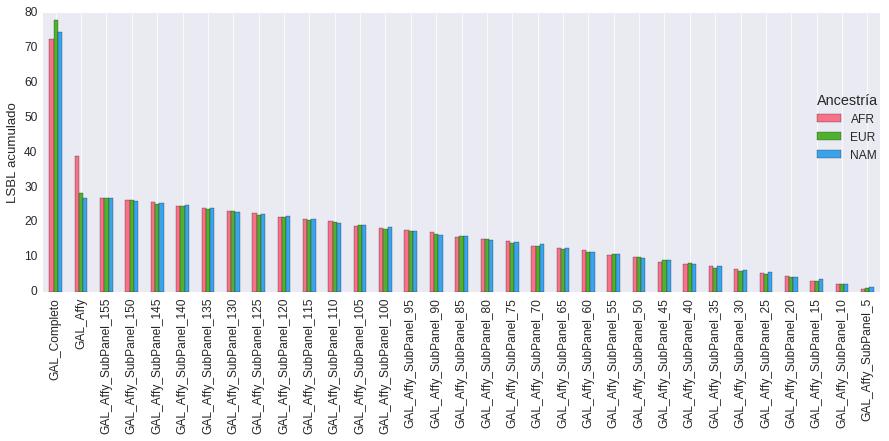

In [144]:
cum_lsbl = pd.DataFrame({})
for panel_label in all_gal_panels():
    rs_ids = Panel(panel_label).snps.index
    panel_cum_lsbl = galanter_lsbl.loc[rs_ids].groupby('population').sum()['LSBL(Fst)']
    panel_cum_lsbl.name = panel_label
    cum_lsbl = cum_lsbl.append(panel_cum_lsbl)

fig, ax = plt.subplots(figsize=(15, 5))
cum_lsbl.plot(ax=ax, kind='bar', rot=90, color=sns.color_palette('husl', 3))
ax.set_ylabel("LSBL acumulado")
ax.legend(fancybox=True, loc="best", bbox_to_anchor=(1.01, .75),
          title="Ancestría")
ax.set_xlim([-0.5, len(cum_lsbl.index) - 0.5])
ax.set_xticks(np.arange(len(cum_lsbl.index)))
ax.set_xticklabels(cum_lsbl.index, rotation=90)
sns.despine(left=True)
ax.yaxis.grid(False)

filepath = '/home/juan/tesina/charts/panel_analyses/LSBL_acumulado_por_ancestria_y_subpanel'
plt.savefig(filepath, bbox_inches='tight', dpi=300)
print(filepath)
print('Esto es una razón para esperar una peor estimación de GAL_Affy que de su subpanel inmediato.')
plt.show()